# Simple Convolutional Neural Network MNIST demo
## Julia/Flux notes for first-timers 

Adapted from the model zoo: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl

Also see: https://www.linkedin.com/pulse/creating-deep-neural-network-model-learn-handwritten-digits-mike-gold/

And Julia's **Flux** package examples here:

https://github.com/FluxML/Flux.jl/blob/master/docs/src/models/basics.md

For the MNIST example using gpu's see: https://nextjournal.com/sdanisch/julia-gpu-programming


In [ ]:
#using Pkg
#Pkg.add("Flux")
#etc., 

In [ ]:
#Because so much is under development, it is important to check versions and
#update as needed.

#using Pkg
#Pkg.update()
#Pkg.installed()
#Pkg.update("Flux")

If you haven't done it yet, you'll need to install the packages below, using commands above:

    using Pkg

    Pkg.add("Flux")

In [ ]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition

In [2]:
#using LinearAlgebra  # only for functions to help analyze and understand arrays
using Colors, FileIO, ImageShow # for image display

### Read in and format the MNIST training data

image dimensions: (28, 28). number of images: 60000


,,,,,,

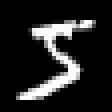
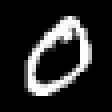
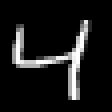
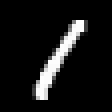
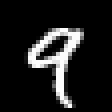
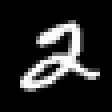
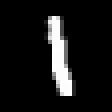

In [4]:
# Read in MNIST digits, set up training set

imgs = MNIST.images();
println("image dimensions: ",size(float.(imgs[1])),". number of images: ",length(imgs))
# use typeof(imgs) to see the data structure. note that the image data is in an image format
# if in floating point format, you could visualize the 2nd image with: Gray.(float.(imgs[2]))
imgs[1:7] # inspect the first seven images

In [5]:
MNIST.labels()[1:7] # inspect the first seven labels

7-element Array{Int64,1}:
 5
 0
 4
 1
 9
 2
 1

In [6]:
labels = onehotbatch(MNIST.labels(), 0:9); # convert "0" through "9" labels to a one hot code
@show size(labels)
@show labels[:,2]; # inspect the 10 element boolean "one hot" coding of the 2nd image, i.e. 2nd column

size(labels) = (10, 60000)
labels[:, 2] = Bool[true, false, false, false, false, false, false, false, false, false]


The structure of the input data to train! (below) needs to be in a format that Conv() understands. We can get documentation for Conv() using the macro @doc(Conv), or ?Conv. The documentation says that the input data should be stored in WHCN (width, height, #channels and # in batch) format.

In [7]:
@doc(Conv);

If the 60,000 image-label pairs are divided up into batches of 1000, the data array for a batch should be: 28x28x1x1000, and there should be 60 batches. In the model-zoo example, data formatting is done concisely in one line:

In [8]:
# Partition into batches of size 1,000
train = [(cat(float.(imgs[i])..., dims = 4), labels[:,i])
         for i in partition(1:60000, 1000)];

There are several functions and operations here that are used to format the training data:
cat(), partition(), and the use of list comprehension for array construction. Before explaining these, let's use the macro @show to inspect and compare the data structure of **imgs** to **train**. Then we'll spot check that the second image and label in the first batch makes sense.

In [9]:
@show typeof(imgs);
# dump(imgs[1][24,24])
@show length(imgs);
@show typeof(train);
@show length(train);

typeof(imgs) = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
length(imgs) = 60000
typeof(train) = Array{Tuple{Array{Float64,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}},1}
length(train) = 60


In [10]:
typeof(float.(imgs))

Array{Array{Float64,2},1}

We can pull out the first image-label training batch with train[1],and then the first batch of images with: train[1][1], and the first batch of labels with train[1][2].

In [11]:
@show typeof(train[1])
@show typeof(train[1][1]);
@show typeof(train[1][2]);
@show size(train[1][1]);
@show size(train[1][2]);

typeof(train[1]) = Tuple{Array{Float64,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}}
typeof((train[1])[1]) = Array{Float64,4}
typeof((train[1])[2]) = Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}
size((train[1])[1]) = (28, 28, 1, 1000)
size((train[1])[2]) = (10, 1000)


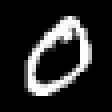

In [12]:
Gray.(train[1][1][:,:,1,2]) #show the second 28x28 image
                            #in channel 1 (there is only one)

In [13]:
train[1][2][:,2] # pull out the second column of one hot vectors.

10-element Flux.OneHotVector:
  true
 false
 false
 false
 false
 false
 false
 false
 false
 false

Back to cat() and partition().  The above training images in **imgs** are organized in an array of 60000 28x28 pictures.  float.(imgs[i]) converts the Gray pictures type to floating points, Float64. The use of "." after float maps the float() function over each element of imgs[i]. 

cat(float.(imgs[i])..., dims = 4) restructures the imgs array into four dimensions: width x height x channels x batch.

In [14]:
# Prepare test set (first 1,000 images)
tX = cat(float.(MNIST.images(:test)[1:1000])..., dims = 4)
tY = onehotbatch(MNIST.labels(:test)[1:1000], 0:9);

### Set up network architecture, define the loss function

In [15]:
m = Chain(
  Conv((2,2), 1=>16, relu),
  x -> maxpool(x, (2,2)),
  Conv((2,2), 16=>8, relu),
  x -> maxpool(x, (2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(288, 10), softmax)

#m(train[1][1])

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

evalcb = throttle(() -> @show(accuracy(tX, tY)), 10)
opt = ADAM(Flux.params(m));

┌ Warning: ADAM(params) is deprecated; use ADAM(η::Float64) instead
│   caller = top-level scope at In[15]:16
└ @ Core In[15]:16


### Train

In [16]:
#To keep it quick, run only twice through
# use @time macro to benchmark train
@time for i = 1:2
    Flux.train!(loss, train, opt, cb = evalcb)
end

┌ Warning: train!(loss, data, opt) is deprecated; use train!(loss, params, data, opt) instead
│   caller = ip:0x0
└ @ Core :-1


accuracy(tX, tY) = 0.168
accuracy(tX, tY) = 0.391
accuracy(tX, tY) = 0.627
accuracy(tX, tY) = 0.735
accuracy(tX, tY) = 0.787
accuracy(tX, tY) = 0.815
accuracy(tX, tY) = 0.845
 86.061157 seconds (413.48 M allocations: 73.318 GiB, 24.16% gc time)


In [17]:
accuracy(tX, tY)

0.845

### Test an image from the test set

Predicted: [6]


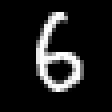

In [18]:
using Colors, FileIO, ImageShow
N = 22
#img = tX[:, :, 1:1, N:N]
img = tX[:, :, 1:1, N:N]
println("Predicted: ", Flux.onecold(m(img)) .- 1)
Gray.(collect(tX[:, :, 1, N]))

### Appendix

#### Using the MLDdatasets instead of Flux's

https://github.com/JuliaML/MLDatasets.jl

In [ ]:
using MLDatasets
using Base.Iterators: partition
using Flux: onehotbatch

images_tr, labels_tr = MLDatasets.MNIST.traindata()
tX,  tY  = MLDatasets.MNIST.testdata()

trainIndex = randperm(size(images_tr)[end])[1:2000]

train = []
for batch in partition(1:2000, 50)
    images_tr_float = Float64.(images_tr[:, :, batch])
    images_tr_reshape = reshape(images_tr_float, (28, 28, 1, length(batch)))
    labels_tr_onehot = onehotbatch(labels_tr[batch], 0:9)
    push!(train, (images_tr_reshape, labels_tr_onehot))
end

####  MNIST classification without convolution, and with some alternate syntax

From: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl

In [ ]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated

# Classify MNIST digits with a simple multi-layer-perceptron
imgs = MNIST.images()

# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...)

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9)

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax)

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM(params(m))

Flux.train!(loss, dataset, opt, cb = throttle(evalcb, 10))

println("acc X,Y ", accuracy(X, Y))

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...)
tY = onehotbatch(MNIST.labels(:test), 0:9)

println("acc tX, tY ", accuracy(tX, tY))